<h1 style="text-align:center">Advanced Clustering Analytics in Enology: A Comprehensive Study of Wine Characteristics Using Machine Learning Techniques</font></h1>  
<h2 style="text-align:center">Sai Sanwariya Narayan</h2>  

In [1]:
# Import necessary PySpark modules
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Create a Spark session
spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

In [2]:
df_raw = spark.read.csv("/storage/home/cluster_data.csv",header = False, inferSchema=True)

In [3]:
# Get the names of all the columns in the DataFrame
column_names = df_raw.columns

# Print the column names
for column_name in column_names:
    print(column_name)

_c0
_c1


## Devise a function that wraps around the KMeans fit that pyspark provides

In [4]:
# Lets define a KMeans fit function since we'll be calling this multiple times
def fit_kmeans(df_input,num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)
        
    #Get the Cluster Center
    cluster_center = model.clusterCenters()
    
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the silhouette score
    print(f"Silhouette Score: {silhouette_score}")
    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    print(f"Within cluster sum of squares: {wcss}")
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

## Preparing the DF for the K-means algorithm using VectorAssembler

In [5]:
assembler = VectorAssembler(inputCols=column_names, outputCol="features")
df_vector = assembler.transform(df_raw)

## Run a first fit to make sure your function works

In [6]:
k = 2
clustered_data, _, _ = fit_kmeans(df_vector,num_cluster_centers=k)

Silhouette Score: 0.6103051103940196
Within cluster sum of squares: 439049.99861031695


## Constructing a function to perform a visualization of our clustered data in 2 dimensions

In [7]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the feature values
    feature1 = pandas_df[feature_1]
    feature2 = pandas_df[feature_2]
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], label=f'Cluster {cluster_id}')
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

## Performing a visualization

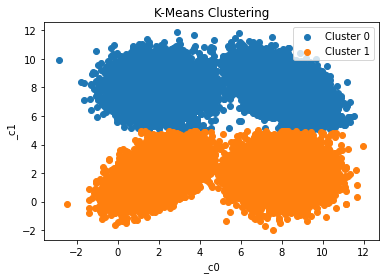

In [8]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "_c0"
feature_2 = "_c1"

visualize_clusters_2D(clustered_data, feature_1, feature_2, k)

## Perform a hyperparameter sweep for various values of k

Silhouette Score: 0.6103051103940196
Within cluster sum of squares: 439049.99861031695


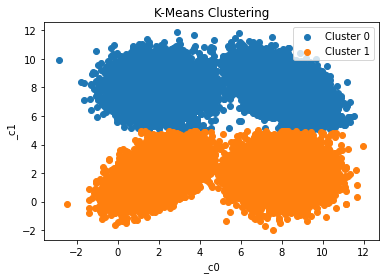

Silhouette Score: 0.6468414281267254
Within cluster sum of squares: 254334.35808853444


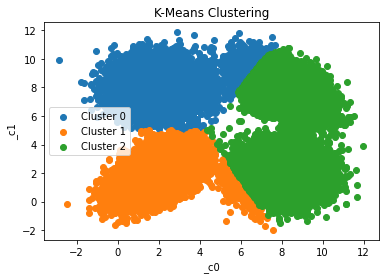

Silhouette Score: 0.8630993813297325
Within cluster sum of squares: 79108.69822463067


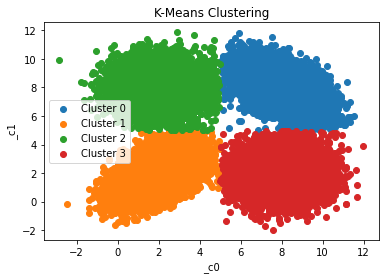

Silhouette Score: 0.7797247086598739
Within cluster sum of squares: 69595.91056831276


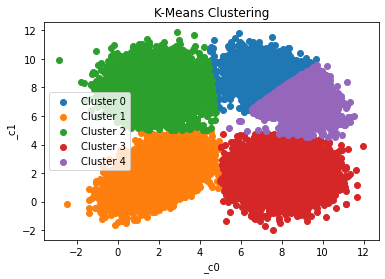

Silhouette Score: 0.6973431993553112
Within cluster sum of squares: 60042.31124630651


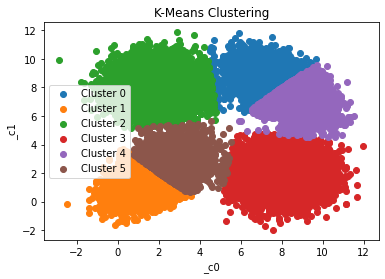

Silhouette Score: 0.6636606265424212
Within cluster sum of squares: 57273.983909910785


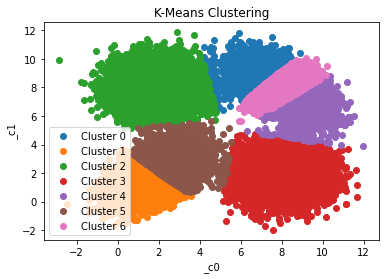

Silhouette Score: 0.5464143287613094
Within cluster sum of squares: 53937.02893599361


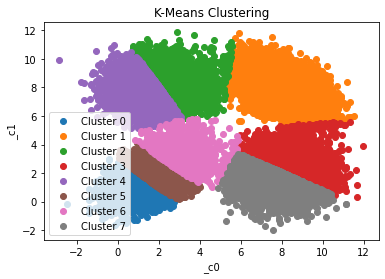

Silhouette Score: 0.5843493346196407
Within cluster sum of squares: 46853.33871321757


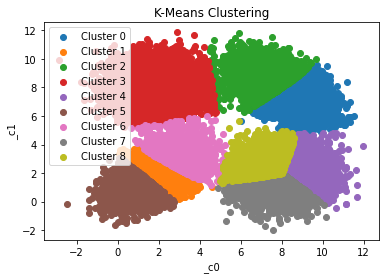

Silhouette Score: 0.5132968722042511
Within cluster sum of squares: 41238.22866565775


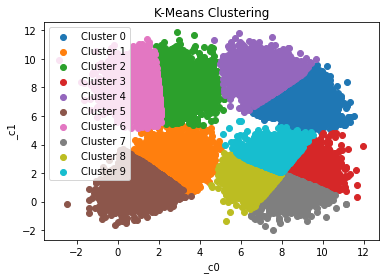

Silhouette Score: 0.5039630811275556
Within cluster sum of squares: 36380.46210039059


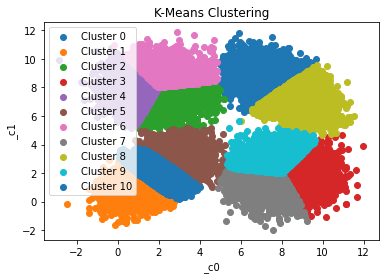

Silhouette Score: 0.48907676666210675
Within cluster sum of squares: 36951.14334923416


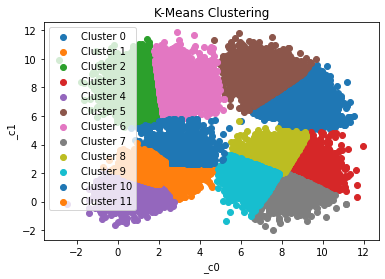

In [9]:
# Let us perform a hyperparameter sweep
k_values = range(2, 13)  # Example: Try K from 2 to 10

silhouette_scores = []
wcss_scores = []

for k in k_values:
    clustered_data, silhouette_score, wcss = fit_kmeans(df_vector, num_cluster_centers=k)
    silhouette_scores.append(silhouette_score)
    wcss_scores.append(wcss)

    # Convert the DataFrame to a Pandas DataFrame for visualization
    feature_1 = "_c0"
    feature_2 = "_c1"
    
    visualize_clusters_2D(clustered_data, feature_1, feature_2, k)

## Plotting the Elbow curve

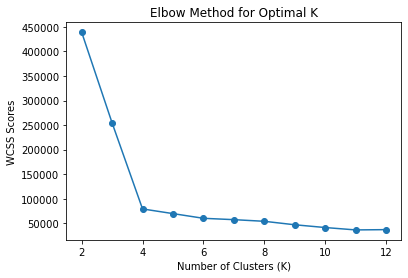

In [10]:
# Plot the Elbow Method curve
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Plotting the Silhouette curve

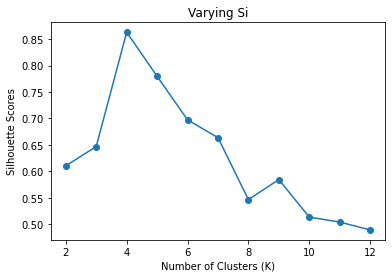

In [11]:
# Plot the Silhouette
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Varying Si")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Scores")
plt.show()

## Clustering task using Bisecting K-means

In [12]:
from pyspark.ml.clustering import BisectingKMeans

## Clustering function as defined previously but using `BisectingKMeans()` this time

In [13]:
# Lets define a KMeans fit function since we'll be calling this multiple times
def fit_bi_kmeans(df_input,num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    bkmeans = BisectingKMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = bkmeans.fit(df_input)
    
    #Get the Cluster Center
    cluster_center = model.clusterCenters()

    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the silhouette score
    print(f"Silhouette Score: {silhouette_score}")
    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    print(f"Within cluster sum of squares: {wcss}")
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

## Performing a hyperparameter sweep for various values of k

Silhouette Score: 0.6103051103940196
Within cluster sum of squares: 439049.99861031695


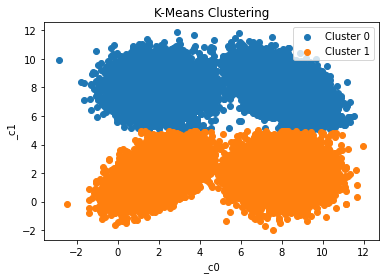

Silhouette Score: 0.6468414281267254
Within cluster sum of squares: 254334.35808853444


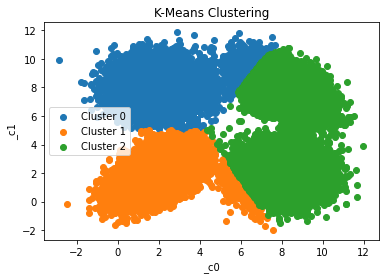

Silhouette Score: 0.8630993813297325
Within cluster sum of squares: 79108.69822463067


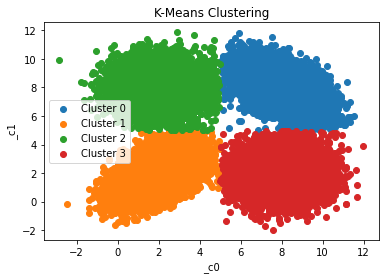

Silhouette Score: 0.7797247086598739
Within cluster sum of squares: 69595.91056831276


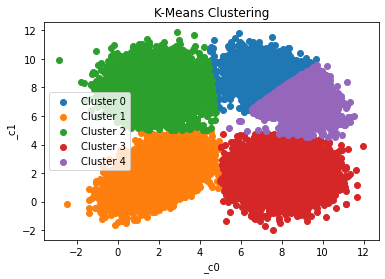

Silhouette Score: 0.6973431993553112
Within cluster sum of squares: 60042.31124630651


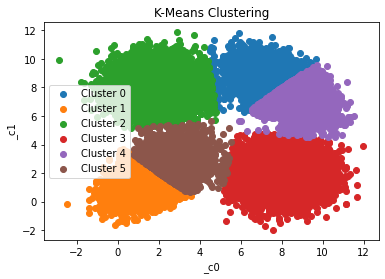

Silhouette Score: 0.6636606265424212
Within cluster sum of squares: 57273.983909910785


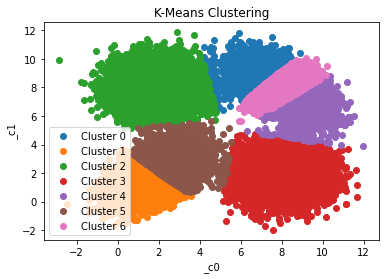

Silhouette Score: 0.5464143287613094
Within cluster sum of squares: 53937.02893599361


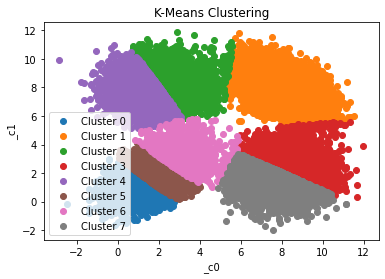

Silhouette Score: 0.5843493346196407
Within cluster sum of squares: 46853.33871321757


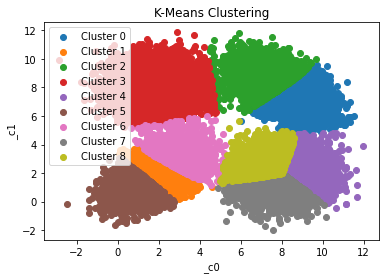

Silhouette Score: 0.5132968722042511
Within cluster sum of squares: 41238.22866565775


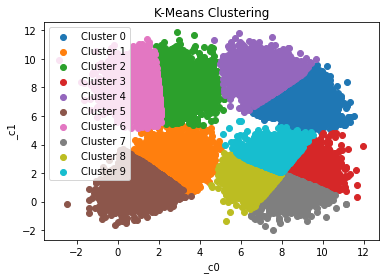

Silhouette Score: 0.5039630811275556
Within cluster sum of squares: 36380.46210039059


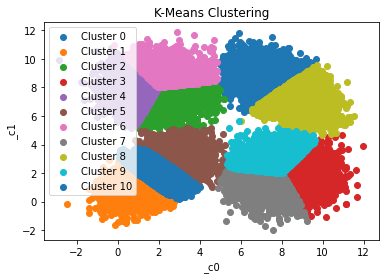

Silhouette Score: 0.48907676666210675
Within cluster sum of squares: 36951.14334923416


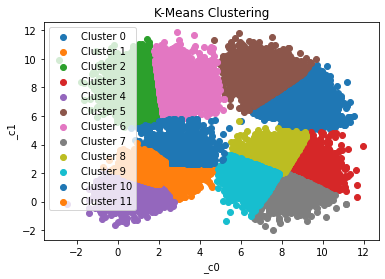

In [14]:
# Let us perform a hyperparameter sweep
k_values = range(2, 13)  # Example: Try K from 2 to 10

silhouette_scores = []
wcss_scores = []

for k in k_values:
    clustered_data, silhouette_score, wcss = fit_kmeans(df_vector, num_cluster_centers=k)
    silhouette_scores.append(silhouette_score)
    wcss_scores.append(wcss)

    # Convert the DataFrame to a Pandas DataFrame for visualization
    feature_1 = "_c0"
    feature_2 = "_c1"
    
    visualize_clusters_2D(clustered_data, feature_1, feature_2, k)

## Plotting the Elbow curve

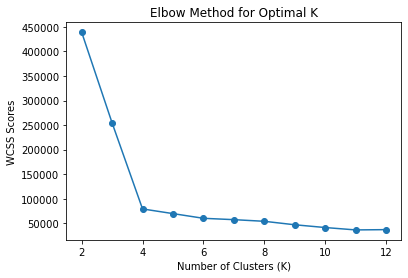

In [15]:
# Plot the Elbow Method curve
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Plotting the Silhouette curve

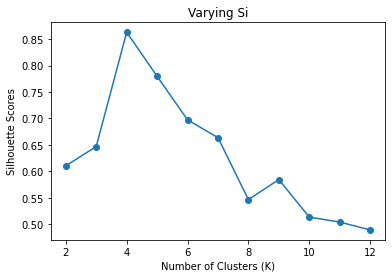

In [16]:
# Plot the Silhouette
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Varying Si")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Scores")
plt.show()

### KMeans fitting procedure for the `wine-clustering.csv` data set to see elbow curves for this newer data.

Alcohol
Malic_Acid
Ash
Ash_Alcanity
Magnesium
Total_Phenols
Flavanoids
Nonflavanoid_Phenols
Proanthocyanins
Color_Intensity
Hue
OD280
Proline
 
Silhouette Score: 0.8213603513331723
Within cluster sum of squares: 4543749.61453186


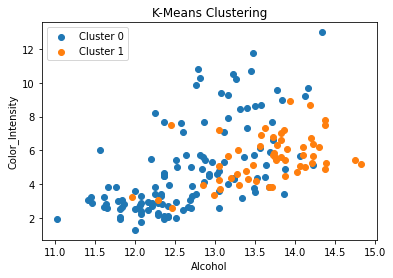

 
Silhouette Score: 0.7209450863531623
Within cluster sum of squares: 2629315.194018101


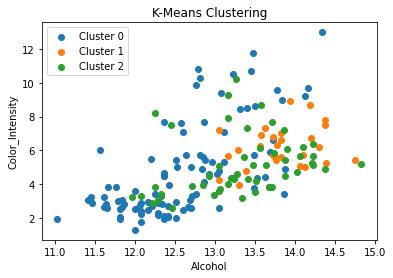

 
Silhouette Score: 0.7285373821819222
Within cluster sum of squares: 1333139.2086165315


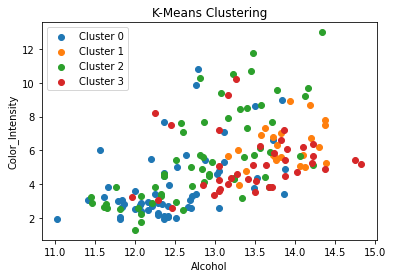

 
Silhouette Score: 0.6773092569860311
Within cluster sum of squares: 1012139.5962003631


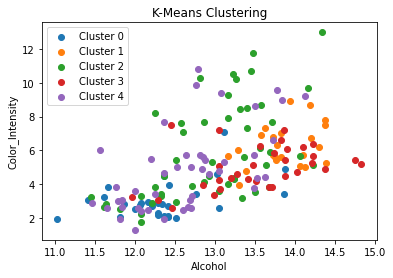

 
Silhouette Score: 0.7061287386109124
Within cluster sum of squares: 683806.0589670824


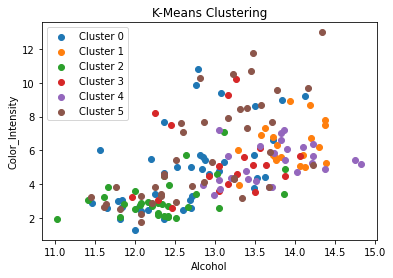

 
Silhouette Score: 0.7332880359043128
Within cluster sum of squares: 414752.8738392505


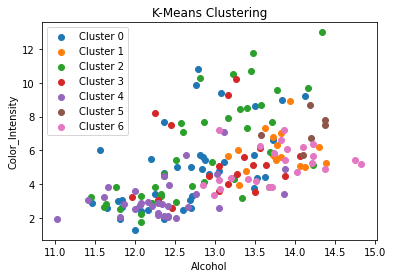

 
Silhouette Score: 0.6947845533746264
Within cluster sum of squares: 349752.3866313902


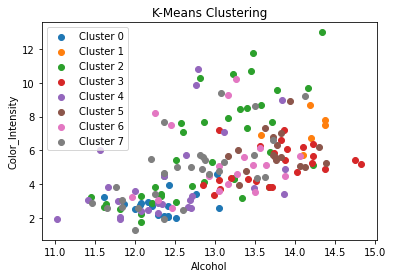

 
Silhouette Score: 0.7058059559187329
Within cluster sum of squares: 278445.8253849511


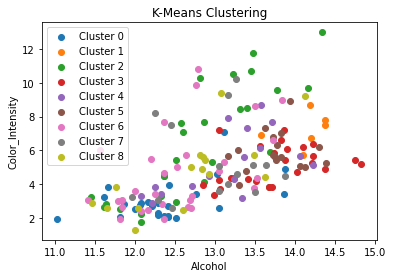

 
Silhouette Score: 0.6810238482437947
Within cluster sum of squares: 231025.4036575438


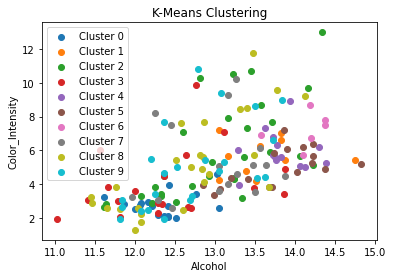

 
Silhouette Score: 0.6502595408820634
Within cluster sum of squares: 223070.17361909043


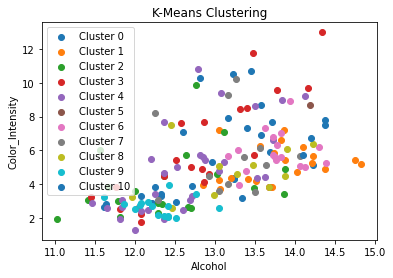

 
Silhouette Score: 0.7017571131724831
Within cluster sum of squares: 175733.23241559774


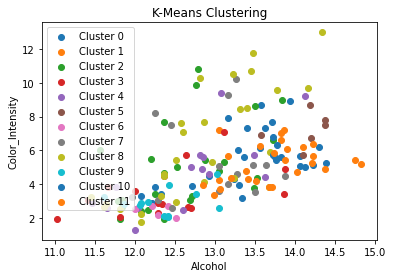

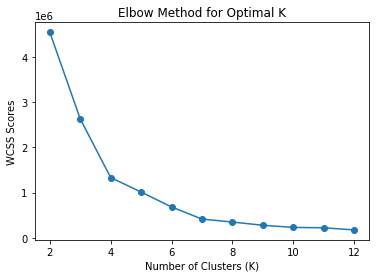

In [17]:
df_raw = spark.read.csv("/storage/home/wine-clustering.csv",header = True, inferSchema=True)

# Get the names of all the columns in the DataFrame
column_names = df_raw.columns

# Print the column names
for column_name in column_names:
    print(column_name)    

# Lets define a KMeans fit function since we'll be calling this multiple times
def fit_kmeans(df_input,num_cluster_centers=3):
    
    # Create a K-Means instance
    kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)

    #Get the Cluster Center
    cluster_center = model.clusterCenters()
    
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)


    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the silhouette score
    print(" ")
    print(f"Silhouette Score: {silhouette_score}")
    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    print(f"Within cluster sum of squares: {wcss}")
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss    
    
assembler = VectorAssembler(inputCols=column_names, outputCol="features")
df_vector = assembler.transform(df_raw)

# Let us perform a hyperparameter sweep
k_values = range(2, 13)  # Example: Try K from 2 to 10

silhouette_scores = []
wcss_scores = []

for k in k_values:
    clustered_data, silhouette_score, wcss = fit_kmeans(df_vector, num_cluster_centers=k)
    silhouette_scores.append(silhouette_score)
    wcss_scores.append(wcss)

    # Convert the DataFrame to a Pandas DataFrame for visualization
    feature_1 = "Alcohol"
    feature_2 = "Color_Intensity"
    
    visualize_clusters_2D(clustered_data, feature_1, feature_2, k)
    
# Plot the Elbow Method curve
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()    

In [18]:
# Stop the Spark session
spark.stop()